<a href="https://colab.research.google.com/github/DaDosValle/Analise_Preditiva-Machine_Learning-TelecomX/blob/main/Analise_Preditiva_TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Modelos de classificação de churn (evasão) clientes Telecom X**

#### Quem são os clientes com maior risco de evasão?
#### Quais variáveis mais influenciam esse comportameto?
#### Que tipo de perfil a empresa precisa manter mais próximo?

### - Análise exploratória dos dados.


In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC




In [61]:
dados = pd.read_csv('/content/dados_tratados.csv')

In [62]:
dados.shape

(7043, 18)

In [63]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   churn                    7043 non-null   int64  
 1   sexo                     7043 non-null   object 
 2   idoso                    7043 non-null   int64  
 3   possui parceiro          7043 non-null   int64  
 4   possui dependentes       7043 non-null   int64  
 5   tempo contrato           7043 non-null   int64  
 6   servico telefone         7043 non-null   int64  
 7   multiplas linhas         7043 non-null   int64  
 8   servico internet         7043 non-null   object 
 9   suporte tecnico          7043 non-null   int64  
 10  streaming tv             7043 non-null   int64  
 11  streaming filmes         7043 non-null   int64  
 12  contrato conta           7043 non-null   object 
 13  preco diario             7043 non-null   float64
 14  cobrancas mensais       

In [64]:
dados.head()

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,servico internet,suporte tecnico,streaming tv,streaming filmes,contrato conta,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label
0,0,Feminino,0,1,1,9,1,0,DSL,1,1,0,Um ano,2.2,65.6,593.3,527.7,Permaneceram
1,0,Masculino,0,0,0,9,1,1,DSL,0,0,1,Mensal,2.0,59.9,542.4,482.5,Permaneceram
2,1,Masculino,0,0,0,4,1,0,Fibra optica,0,0,0,Mensal,2.5,73.9,280.8,207.0,Saíram
3,1,Masculino,1,1,0,13,1,0,Fibra optica,0,1,1,Mensal,3.3,98.0,1237.8,1139.8,Saíram
4,1,Feminino,1,1,0,3,1,0,Fibra optica,1,1,0,Mensal,2.8,83.9,267.4,183.5,Saíram


In [65]:
px.pie(dados, names='churn_label', width=800, title='Distribuição da Variável Alvo: churn')

In [66]:
px.histogram(dados, x='churn_label', text_auto=True, color='churn_label',
            width=800, height=500,
            title='Distribuição da Variável Alvo: churn'
            )


In [67]:
px.histogram(dados, x='sexo', text_auto=True, color='churn_label',
            barmode='group', width=900, height=500,
            title='Distribuição da Variável categórica: sexo')


In [68]:
px.histogram(dados, x = 'idoso', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: idoso'
             )


In [69]:
px.histogram(dados, x = 'possui parceiro', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Alvo: possui parceiro'
             )

In [70]:
px.histogram(dados, x = 'possui dependentes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: possui dependentes'
             )


In [71]:
px.histogram(dados, x = 'servico telefone', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: servico telefone'
             )

In [72]:
px.histogram(dados, x = 'multiplas linhas', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: multiplas linhas')


In [73]:
dados['servico internet'].value_counts()

,count
servico internet,
Fibra optica,3096
DSL,2421
Nao disponivel,1526


In [74]:
px.histogram(dados, x = 'servico internet', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: servico internet')


In [75]:
px.histogram(dados, x = 'suporte tecnico', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: suporte tecnico'
             )


In [76]:
px.histogram(dados, x = 'streaming tv', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: streaming tv'
             )


In [77]:
px.histogram(dados, x = 'streaming filmes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: streaming filmes'
             )


In [78]:
px.histogram(dados, x = 'contrato conta', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: contrato conta'
             )


In [79]:
px.box(dados, x='tempo contrato', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Númércia: tempo contrato'
             )


In [80]:
px.box(dados, x='preco diario', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numérica: preco diario'
             )


In [81]:
px.box(dados, x='cobrancas mensais', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numérica: cobrancas mensais')



In [82]:
px.box(dados, x='total de encargos', color='churn_label',
       width=900, height=500,
       title='Distribuição da Variável Numércia: total de encargos')



In [83]:
px.box(dados, x='excedente a mensalidade', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numércia: excedente a mensalidade')


In [84]:
dados.describe().round(2)

,churn,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,streaming filmes,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.27,0.16,0.48,0.30,32.37,0.9,0.42,0.29,0.38,0.39,2.16,64.76,2284.33,2219.56
std,0.44,0.37,0.50,0.46,24.56,0.3,0.49,0.45,0.49,0.49,1.00,30.09,2265.95,2246.51
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.60,18.20,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,1.20,35.50,401.90,355.75
50%,0.00,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,2.30,70.40,1398.60,1352.20
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,3.00,89.80,3801.50,3730.10
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,4.00,118.80,8684.80,8567.00


In [85]:
dados.describe(include='O')

,sexo,servico internet,contrato conta,churn_label
count,7043,7043,7043,7043
unique,2,3,3,2
top,Masculino,Fibra optica,Mensal,Permaneceram
freq,3555,3096,3875,5174


In [86]:
dados.head(3)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,servico internet,suporte tecnico,streaming tv,streaming filmes,contrato conta,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label
0,0,Feminino,0,1,1,9,1,0,DSL,1,1,0,Um ano,2.2,65.6,593.3,527.7,Permaneceram
1,0,Masculino,0,0,0,9,1,1,DSL,0,0,1,Mensal,2.0,59.9,542.4,482.5,Permaneceram
2,1,Masculino,0,0,0,4,1,0,Fibra optica,0,0,0,Mensal,2.5,73.9,280.8,207.0,Saíram


### - Prepararando os dados para a modelagem.


In [87]:
dados = pd.get_dummies(dados, columns=[
    'servico internet',
    'contrato conta'
], drop_first=False)

In [88]:
dados['sexo'] = dados['sexo'].map({'Masculino': 1, 'Feminino': 0})

dados['sexo'] = dados['sexo'].astype(int)

In [89]:
colunas = ['servico internet_DSL', 'servico internet_Fibra optica', 'servico internet_Nao disponivel', 'contrato conta_Dois anos', 'contrato conta_Mensal', 'contrato conta_Um ano']

dados[colunas] = dados[colunas].astype(int)

In [90]:
dados.head(3)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,...,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label,servico internet_DSL,servico internet_Fibra optica,servico internet_Nao disponivel,contrato conta_Dois anos,contrato conta_Mensal,contrato conta_Um ano
0,0,0,0,1,1,9,1,0,1,1,...,65.6,593.3,527.7,Permaneceram,1,0,0,0,0,1
1,0,1,0,0,0,9,1,1,0,0,...,59.9,542.4,482.5,Permaneceram,1,0,0,0,1,0
2,1,1,0,0,0,4,1,0,0,0,...,73.9,280.8,207.0,Saíram,0,1,0,0,1,0


In [91]:
dados = dados.drop(['churn_label'], axis=1)

### - Analise de correão entre variáveis.


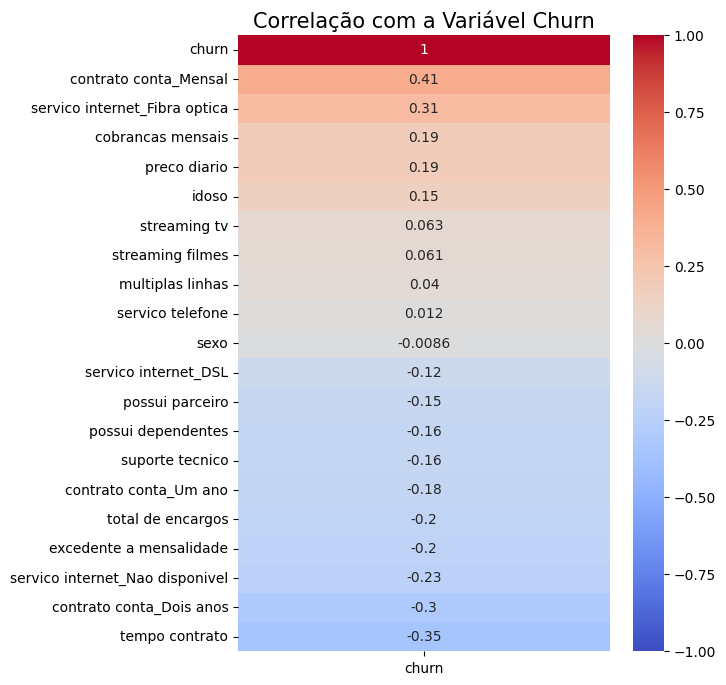

In [92]:
plt.figure(figsize=(6, 8))

# Correlação das variáveis explicativas com a variavel churn
corr_churn = dados.corr(numeric_only=True)[['churn']].sort_values(by='churn', ascending=False)

sns.heatmap(corr_churn, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlação com a Variável Churn', fontsize=15)
plt.show()


In [93]:
# Tratando para evitar multicolinearidade
variaveis_correlacionadas = dados[['tempo contrato','total de encargos','cobrancas mensais']]

variaveis_correlacionadas.corr()

,tempo contrato,total de encargos,cobrancas mensais
tempo contrato,1.000000,0.823814,0.247890
total de encargos,0.823814,1.000000,0.650018
cobrancas mensais,0.247890,0.650018,1.000000


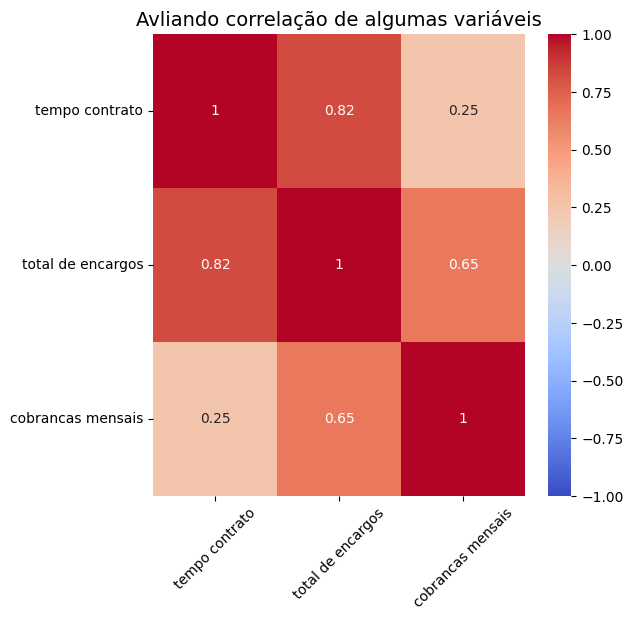

In [94]:
plt.figure(figsize=(6, 6))

# Correlação das variáveis explicativas com a variavel churn
corr_churn_correlacionados = variaveis_correlacionadas.corr(numeric_only=True)

sns.heatmap(corr_churn_correlacionados, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.title('Avliando correlação de algumas variáveis', fontsize=14)
plt.show()


### - Seleção das variáveis

In [113]:
# Seleção da variável resposta/alvo

remover_variaveis = ['total de encargos', 'sexo', 'servico telefone', 'streaming tv', 'streaming filmes', 'churn']

y = dados['churn']

# Seleção das variáveis explicativas
x = dados.drop(remover_variaveis, axis=1)

In [114]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

### -  Treinando modelo de base.

In [115]:
dummy = DummyClassifier()
dummy.fit(x_treino, y_treino)

round(dummy.score(x_teste, y_teste),2)

0.73

### -  Treinando modelo de regressão logistica.

In [116]:
scaler = StandardScaler()

x_treino_scaled = scaler.fit_transform(x_treino)
x_teste_scaled = scaler.transform(x_teste)

In [121]:
log_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_model.fit(x_treino_scaled, y_treino)

LogisticRegression(max_iter=1000, random_state=42)

In [122]:
round(log_model.score(x_teste_scaled, y_teste), 2)

0.79

In [147]:
y_pred = log_model.predict(x_teste_scaled)

y_pred

array([0, 1, 1, ..., 0, 0, 0])

### - Avaliando modelo de regressão logistica

In [148]:
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.78708303761533


In [149]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [150]:
cm = confusion_matrix(y_teste, y_pred)
print(cm)

[[924 111]
 [189 185]]


### - Análise de importância das variáveis regressão logistica

In [197]:
modelo = log_model

In [198]:

coeficientes = pd.DataFrame({
    'Variável': x_treino.columns,
    'Coeficiente': modelo.coef_[0]
})

coeficientes['Impacto Absoluto'] = coeficientes['Coeficiente'].abs()

coeficientes = coeficientes.sort_values(by='Impacto Absoluto', ascending=False)

coeficientes

,Variável,Coeficiente,Impacto Absoluto
3,tempo contrato,-1.379851,1.379851
6,preco diario,-0.802390,0.802390
7,cobrancas mensais,0.775256,0.775256
8,excedente a mensalidade,0.617982,0.617982
11,servico internet_Nao disponivel,-0.473139,0.473139
10,servico internet_Fibra optica,0.398869,0.398869
12,contrato conta_Dois anos,-0.355938,0.355938
13,contrato conta_Mensal,0.335930,0.335930
5,suporte tecnico,-0.208881,0.208881
4,multiplas linhas,0.147596,0.147596


### -  Treinando modelo de árvore de decisão.

In [174]:
arvore = DecisionTreeClassifier(max_depth = 3, random_state =1875)
arvore.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3, random_state=1875)

In [175]:
y_pred = arvore.predict(x_teste)

In [179]:
colunas_selecionadas = ['servico internet_DSL',
                'servico internet_Fibra optica',
                'servico internet_Nao disponivel',
                'idoso)',
                'possui parceiro',
                'possui dependentes',
                'tempo contrato',
                'servico telefone',
                'multiplas linhas',
                'suporte tecnico',
                'preco diario',
                'contrato conta',
                'cobrancas mensais',
                'servico internet_DSL',
                'servico internet_Fibra optica',
                'servico internet_Nao disponivel',
                'contrato conta_Dois anos',
                'contrato conta_Mensal',
                'contrato conta_Um ano',
                ]

In [181]:
arvore.score(x_treino, y_treino)

0.7903798367057153

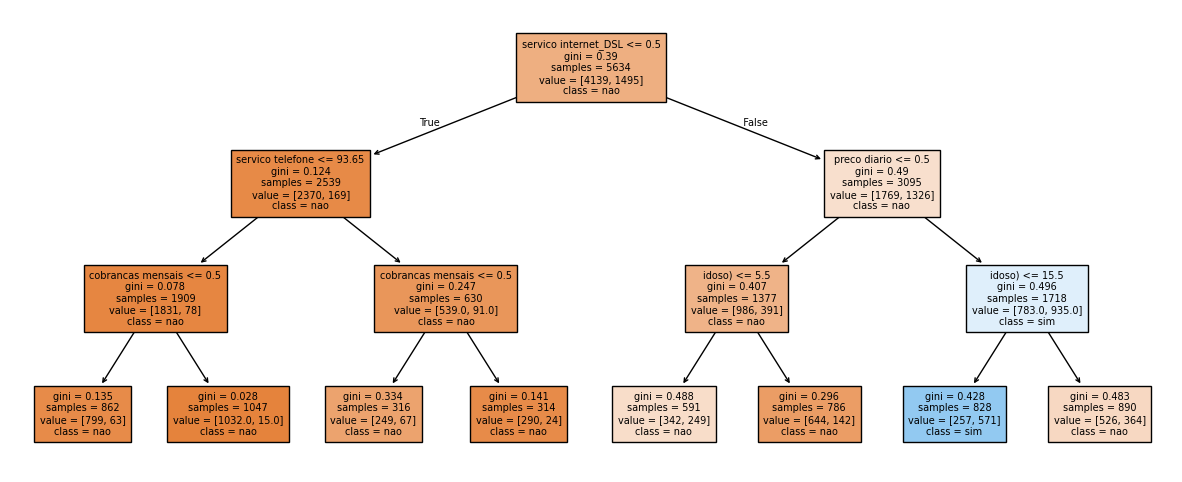

In [184]:
plt.figure(figsize = (15, 6))
plot_tree(arvore, filled = True, class_names = ['nao', 'sim'], fontsize = 7, feature_names = colunas_selecionadas);

### - Avaliando modelo árvore de decisão

In [185]:
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.794180269694819


In [186]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1035
           1       0.70      0.39      0.50       374

    accuracy                           0.79      1409
   macro avg       0.76      0.67      0.69      1409
weighted avg       0.78      0.79      0.77      1409



In [187]:
cm_arvore = confusion_matrix(y_teste, y_pred)
print(cm_arvore)

[[973  62]
 [228 146]]


### - Análise de importância das variáveis árvore de decisão

In [199]:
importancias = pd.DataFrame({
    'Variável': x_treino.columns,
    'Importância': arvore.feature_importances_
})

importancias = importancias.sort_values(by='Importância', ascending=False)

importancias

,Variável,Importância
13,contrato conta_Mensal,0.614231
3,tempo contrato,0.179301
10,servico internet_Fibra optica,0.174148
7,cobrancas mensais,0.017092
12,contrato conta_Dois anos,0.015227
1,possui parceiro,0.000000
0,idoso,0.000000
6,preco diario,0.000000
5,suporte tecnico,0.000000
4,multiplas linhas,0.000000


### -  Treinando modelo de SVM.

In [189]:
svm = SVC(random_state=42)

In [190]:
svm.fit(x_treino_scaled, y_treino)

SVC(random_state=42)

### - Avaliando modelo smv

In [192]:
y_pred_svm = svm.predict(x_teste_scaled)

print("Acurácia:", accuracy_score(y_teste, y_pred))

Acurácia: 0.7984386089425124


In [193]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [194]:
cm_svm = confusion_matrix(y_teste, y_pred)
print(cm_svm)

[[942  93]
 [191 183]]


### - Análise de importância das variáveis SVM

In [201]:
SVC(kernel='linear')

SVC(kernel='linear')

In [202]:
coeficientes_svm = pd.DataFrame({
    'Variável': x_treino.columns,
    'Coeficiente': modelo.coef_[0]
})

coeficientes_svm['Impacto Absoluto'] = coeficientes_svm['Coeficiente'].abs()

coeficientes_svm = coeficientes_svm.sort_values(by='Impacto Absoluto', ascending=False)

coeficientes_svm

,Variável,Coeficiente,Impacto Absoluto
3,tempo contrato,-1.379851,1.379851
6,preco diario,-0.802390,0.802390
7,cobrancas mensais,0.775256,0.775256
8,excedente a mensalidade,0.617982,0.617982
11,servico internet_Nao disponivel,-0.473139,0.473139
10,servico internet_Fibra optica,0.398869,0.398869
12,contrato conta_Dois anos,-0.355938,0.355938
13,contrato conta_Mensal,0.335930,0.335930
5,suporte tecnico,-0.208881,0.208881
4,multiplas linhas,0.147596,0.147596
